# 4 Geocentric models

In [1]:
!pip install -q numpyro arviz causalgraphicalmodels daft

In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/koenrademaker/miniconda3/envs/NUMPYRO/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4.1.1 Normal by addition

In [22]:
# 4.1
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

array([[<Axes: >]], dtype=object)

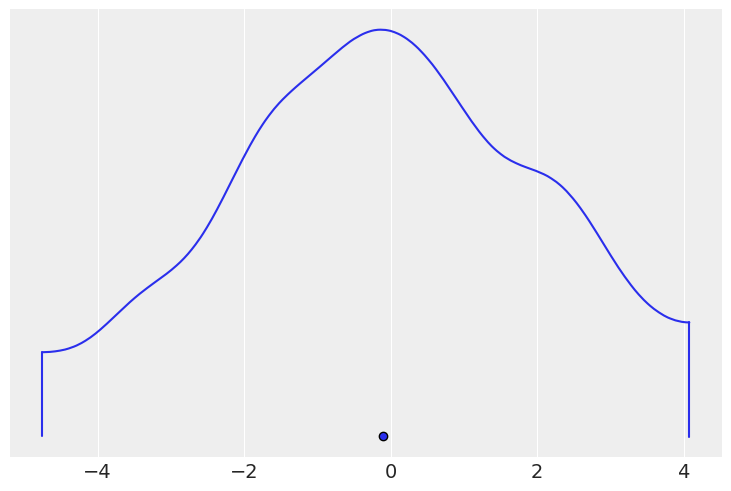

In [23]:
az.plot_density({"": pos})

### 4.1.2 Normal by multiplication

“Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that code for more growth. Suppose also that all of these loci interact with one another, such that each increase growth by a percentage. This means that their effects multiply, rather than add.”

In [28]:
# 4.2
# Sample 12 random numbers between 0-0.1, multiply with 1 + these products.
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

Array(1.7294353, dtype=float32)

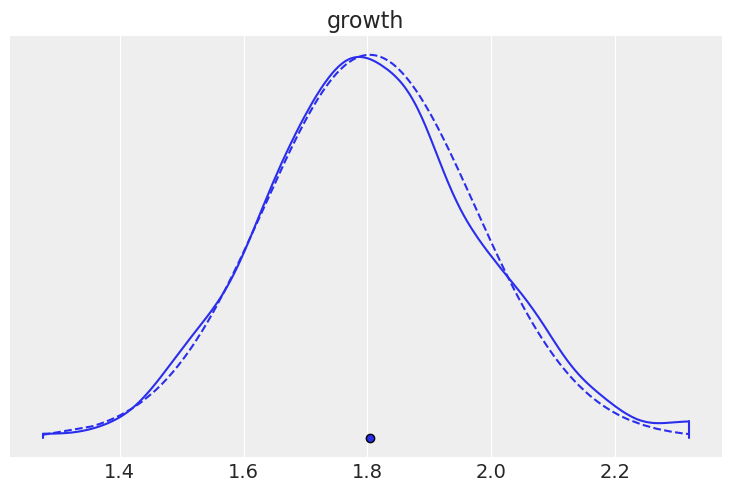

In [39]:
# 4.3
# Calculate distribution of such random products
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000,12)),-1)
az.plot_density({"growth":growth}, hdi_prob=1)
x = jnp.sort(growth)
# Plot a Gaussian with the mean and std of growth values
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

In this case of multiplication of small numbers, we get approximately the same as addition. The smaller the effect of each locus, the better the additive approximation will be. And as such, small effects that multiply together are approximately additive, and so they also tend to stabilize on Gaussian distributions.

In [40]:
# 4.4
big = growth = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000,12)),-1)
small = growth = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000,12)),-1)

array([[<Axes: title={'center': 'small'}>]], dtype=object)

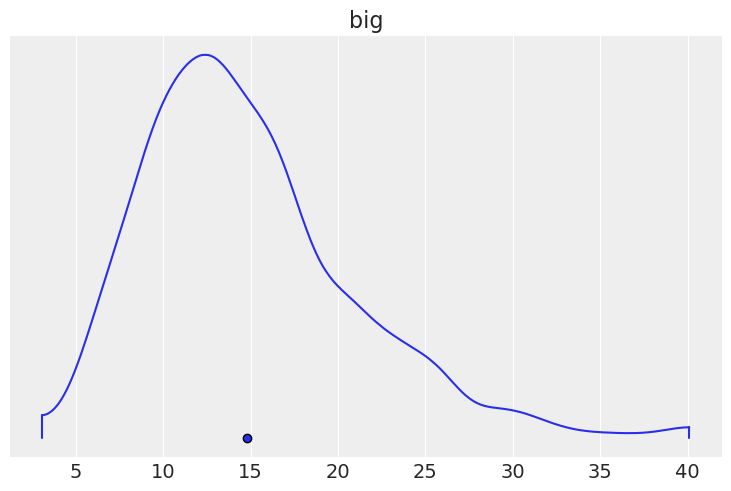

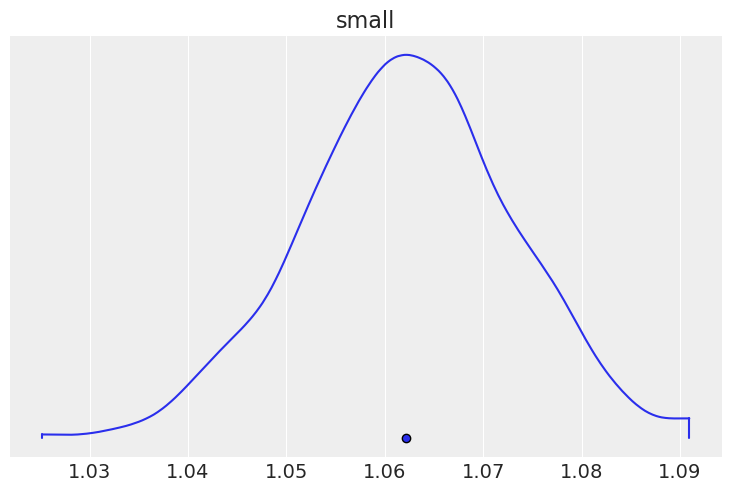

In [46]:
az.plot_density({"big":big}, hdi_prob=1)
az.plot_density({"small":small}, hdi_prob=1)

### 4.1.3 Normal by log-multiplication

array([[<Axes: title={'center': 'log_big'}>]], dtype=object)

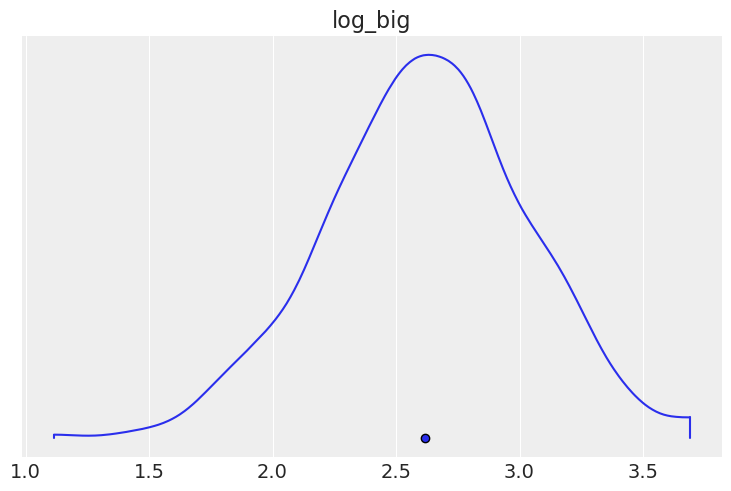

In [52]:
# 4.5
log_big = jnp.log(
    jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000,12)),-1)
)
az.plot_density({"log_big":log_big}, hdi_prob=1)

### 4.1.4 Using Gaussians

$$p(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{{(y-\mu)}^2}{2\sigma^2}\right)$$

## 4.2 A language for describing models

$$ W \sim \text{Binomial}(N,p)$$
$$ p \sim \text{Uniform(0,1)}$$

W was the observed count of water, N was the total number of tosses, p was the proportion of water on the globe. The count W is distributed binomially with sample size N and probability p. The prior for p is assumed to be uniform between zero and one.

In [50]:
# 4.6
w = 6
n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0,1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)

array([[<Axes: title={'center': 'posterior'}>]], dtype=object)

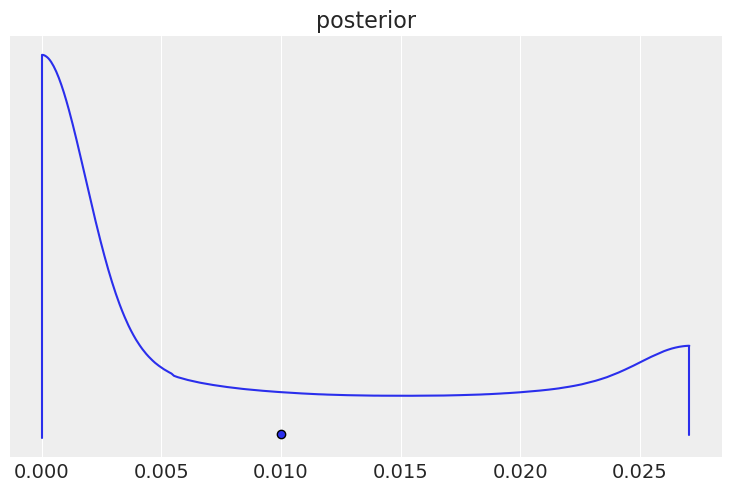

In [54]:
az.plot_density({"posterior":posterior})

## 4.3 Gaussian model of height

In [60]:
# 4.7
Howell = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell

In [62]:
# 4.8
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [65]:
# 4.9
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [66]:
# 4.11
d2 = d[d.age >= 18]

In [67]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  352 non-null    float64
 1   weight  352 non-null    float64
 2   age     352 non-null    float64
 3   male    352 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.8 KB


### 4.3.2 The model

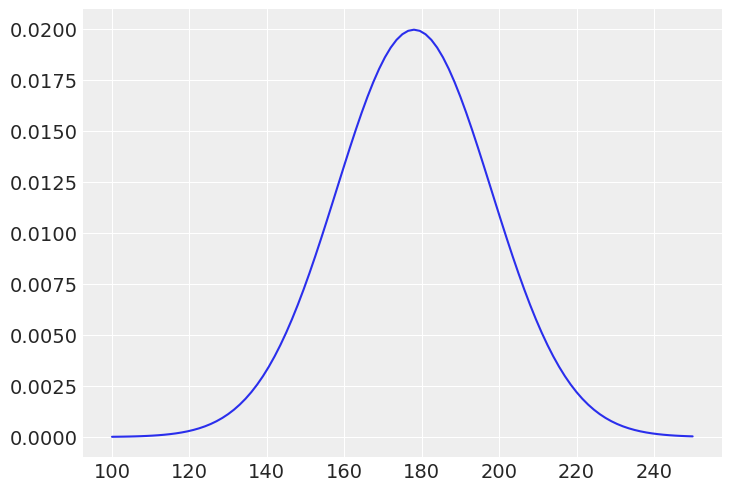

In [75]:
# 4.12
# Plot model priors
x = jnp.linspace(100,250,101)
plt.plot(x, jnp.exp(dist.Normal(178,20).log_prob(x)))
plt.show()

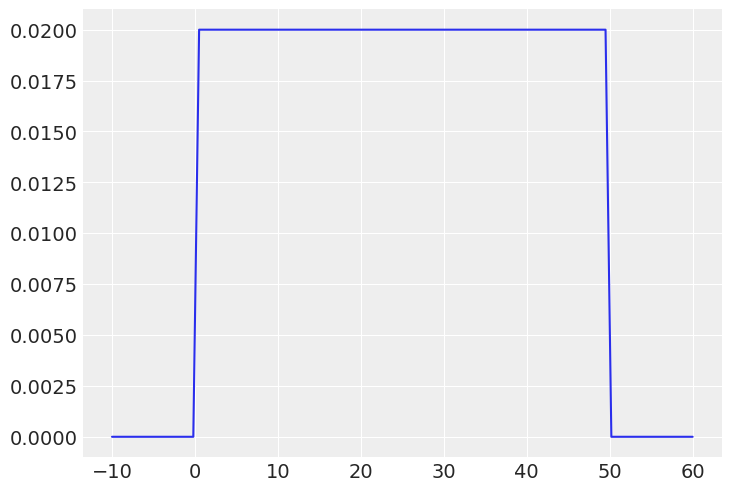

In [77]:
# 4.13
x = jnp.linspace(-10,60,101)
plt.plot(x, jnp.exp(dist.Uniform(0,50, validate_args=True).log_prob(x)))
plt.show()

**Prior predictive simulations**: Quickly simulate heights by sampling from the prior (like the posterior sampling in chapter 3).

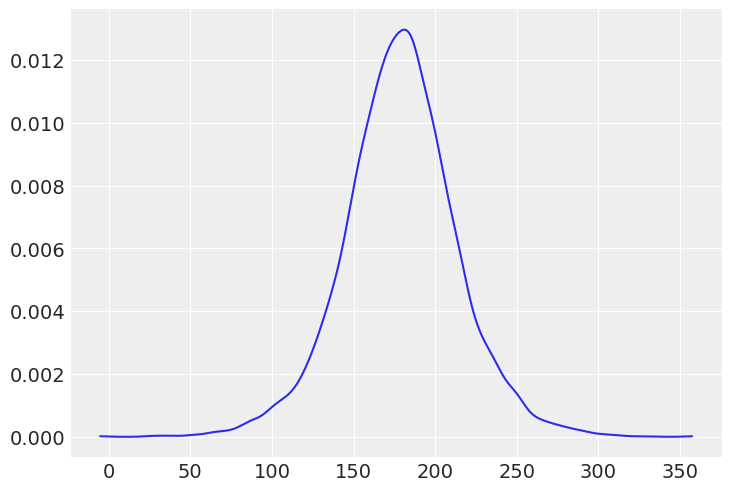

In [83]:
# 4.13
sample_mu = dist.Normal(178,20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0,50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

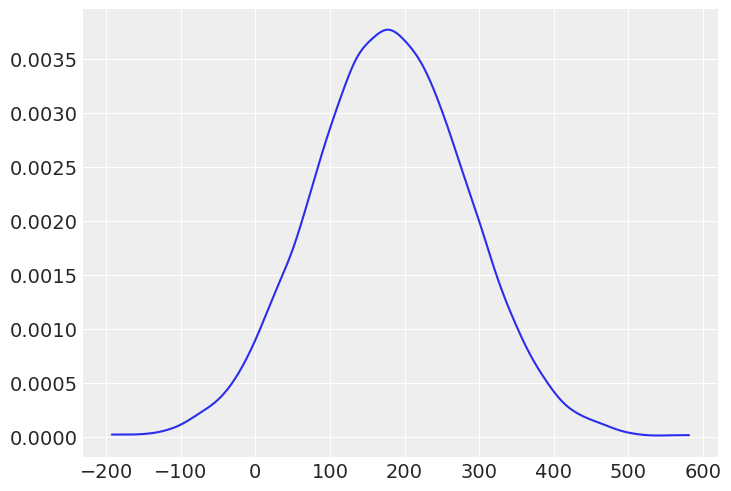

In [84]:
# 4.15
sample_mu = dist.Normal(178,100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

### 4.3.3 Grid approximation of posterior distribution

In [86]:
# 4.16
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

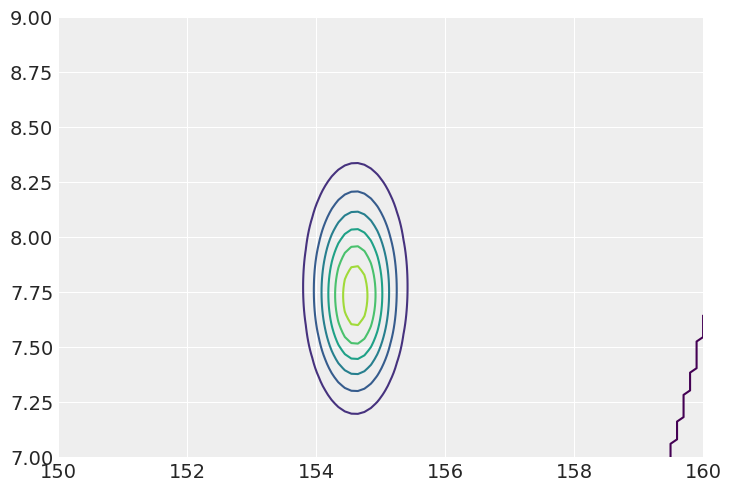

In [87]:
# 4.17
# Contour plot of posterior distribution samples for mu and sigma
plt.contour(
    post["mu"].reshape(100,100),
    post["sigma"].reshape(100,100),
    post["prob"].reshape(100,100)
)
plt.show()

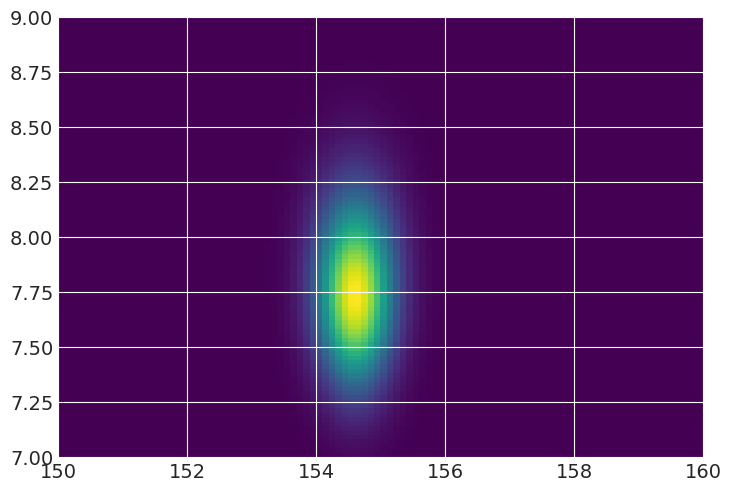

In [88]:
# 4.18
# Simple heatmap
plt.imshow(
    post["prob"].reshape(100,100),
    origin="lower",
    extent=(150,160,7,9),
    aspect="auto",
)
plt.show()

### 4.3.4 Sampling from the posterior

We will again sample values from the posterior distribution, however since there are now two parameters, we want to sample _combinations_ of parameters. In practice, randomly sample rows in proportion to the probability (`prob`) and extract parameter values.

In [91]:
# 4.19
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

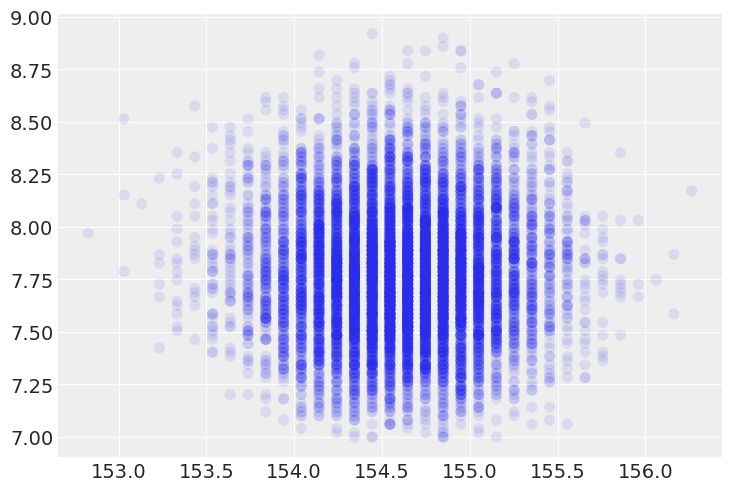

In [92]:
# 4.20
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

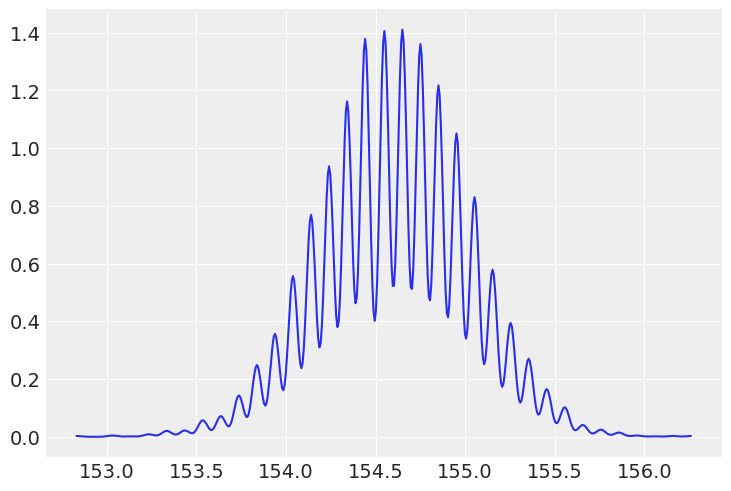

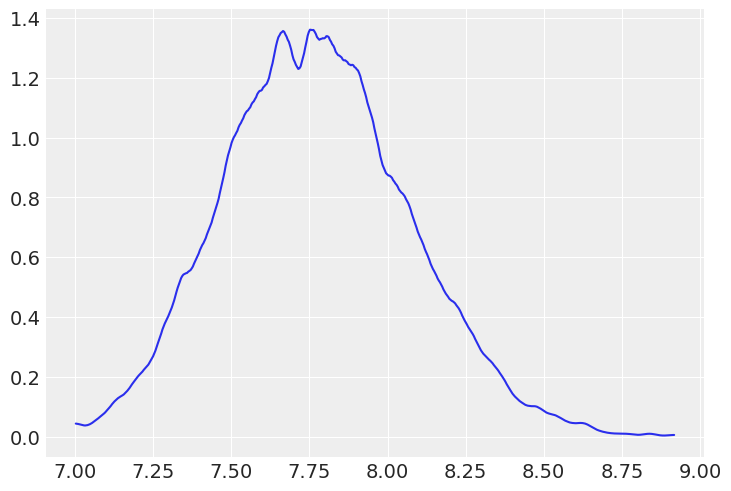

In [94]:
# 4.20
# Plot shapes of marginal posteriors densities of mu and sigma
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

In [95]:
# 4.22
# Posterior compatibility intervals
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


In [96]:
# 4.23
# Overthinking: variance
d3 = d2.height.sample(n=20)

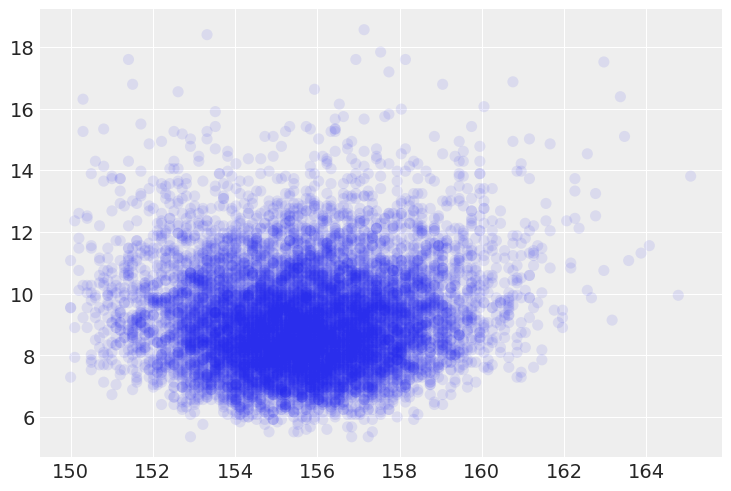

In [98]:
# 4.24
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

This scatter plot shows samples from the posterior density, but this time with a longer tail at the top (higher sigma values).

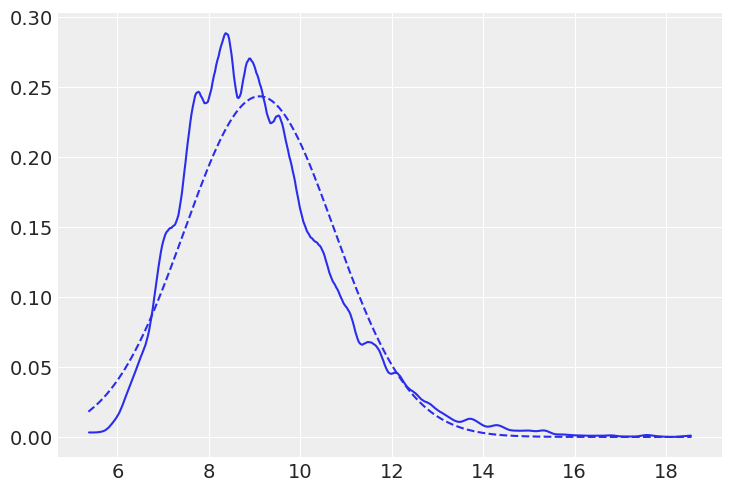

In [99]:
# 4.25
# Marginal posterior density for sigma, averaging over mu
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

Inspecting the marginal posterior density for $\sigma$, averaging over $\mu$, shows a normal approximation with identical mean and variance. Now, we can see that the posterior for $\sigma$ is not Gaussian, but instead has a longer tail of uncertainty towards higher values.

### 4.3.5 Finding the posterior distribution with quadratic approximation

The posterior’s peak will lie at the maximum a posteriori estimate (MAP), and we can get a useful image of the posterior’s shape by using the quadratic approximation of the posterior distribution at this peak.

The quap (R name) function works by using the model definition you were introduced to earlier in this chapter. Each line in the definition has a corresponding definition in the form of R code. The engine inside quap then uses these definitions to define the posterior probability at each combination of parameter values. Then it can climb the posterior distribution and find the peak, its MAP. Finally, it estimates the quadratic curvature at the MAP to produce an approximation of the posterior distribution. Remember: This procedure is very similar to what many non-Bayesian procedures do, just without any priors

In [100]:
# 4.26
Howell = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell
d2 = d[d['age'] >= 18]

In [101]:
# 4.27
# Define a formula list (flist)
def flist(height):
    mu = numpyro.sample('mu', dist.Normal(178,20))
    sigma = numpyro.sample('sigma', dist.Uniform(0,50))
    numpyro.sample("height", dist.Normal(mu,sigma), obs=height)

In [122]:
# 4.28
# Fit model to the data in the dataframe d2
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist,
          m4_1,
          optim.Adam(1),
          Trace_ELBO(),
          height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 10045.77it/s, init loss: 4000.1150, avg. loss [1


In [126]:
# 4.29
# Inspect the posterior distribution, i.e. Gaussian approximations for each paramter's marginal distribution
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.59      0.40    154.59    153.99    155.28    995.05      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.04      1.00



In [124]:
# 4.30
# Quadratic approximation of posterior WITH start values
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|█| 2000/2000 [00:00<00:00, 10180.14it/s, init loss: 1226.0387, avg. loss [1


In [120]:
# 4.31
# Introduce new model with more narrow prior on std of Normal for mu
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

100%|█| 2000/2000 [00:00<00:00, 10688.28it/s, init loss: 1584193.6250, avg. loss



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



“Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter”

### 4.3.6 Sampling from a quadratic approximation

The key thing to understand is that - in order to be able to get samples from a posterior distribution obtained from the quadratic approximation - when there is more than one parameter dimension - here $\mu$ and $\sigma$ - the posterior is in fact just a multi-dimensional Gaussian.

Hence, not only standard deviations for all parameters are calculated, but also the **covariance** among pairs of parameters. Together, the list of means and matrix of variances and covariances are sufficient to describe a multi-dimensional Gaussian.

In [127]:
# 4.32
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis = 0))
vcov

Array([[0.16249587, 0.00154646],
       [0.00154646, 0.08733496]], dtype=float32)

In [128]:
# 4.33
# Diagonal (variances)
print(jnp.diagonal(vcov))
# Correlation matrix
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16249587 0.08733496]
[[1.         0.01298147]
 [0.01298147 1.        ]]


“The two-element vector in the output is the list of variances. If you take the square root of this vector, you get the standard deviations that are shown in precis output. The two-by-two matrix in the output is the correlation matrix. Each entry shows the correlation, bounded between −1and +1, for each pair of parameters. The 1’s indicate a parameter’s correlation with itself. If these values were anything except 1, we would be worried. The other entries are typically closer to zero, and they are very close to zero in this example. This indicates that learning μ tells us nothing about σ and likewise that learning σ tells us nothing about μ.” 

Instead of sapling single values from a simpel Gaussian, we now sample vectors of values from a multi-dimensional Gaussian.

In [129]:
# 4.34
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [Array(154.2356, dtype=float32),
  Array(154.47672, dtype=float32),
  Array(154.97047, dtype=float32),
  Array(154.20374, dtype=float32),
  Array(155.48271, dtype=float32),
  Array(154.81831, dtype=float32)],
 'sigma': [Array(7.5602665, dtype=float32),
  Array(7.306454, dtype=float32),
  Array(7.27963, dtype=float32),
  Array(7.8118353, dtype=float32),
  Array(7.9042172, dtype=float32),
  Array(7.978001, dtype=float32)]}

In [130]:
# 4.35
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.41    154.60    153.93    155.24   9926.99      1.00
     sigma      7.75      0.29      7.74      7.29      8.23   9502.45      1.00



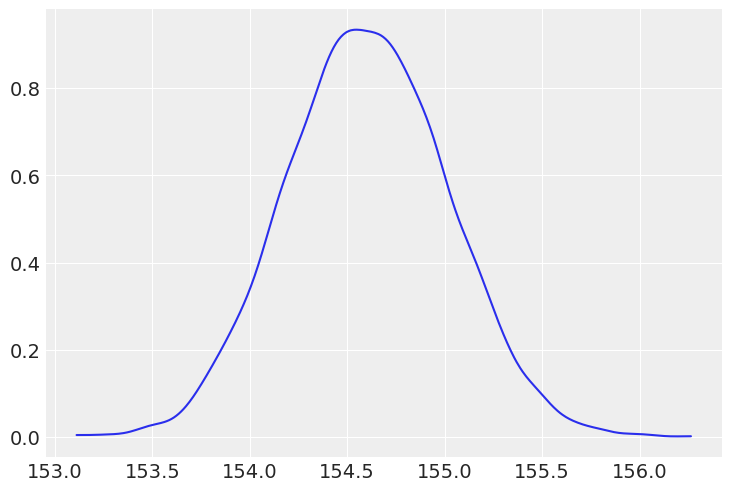

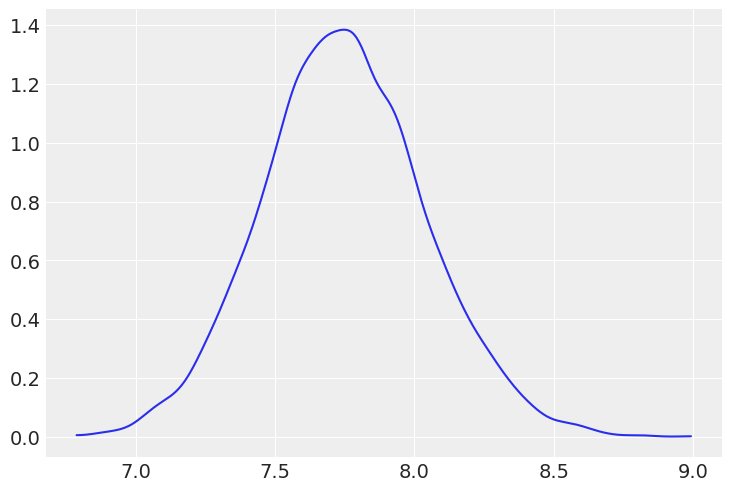

In [135]:
# Plot shapes of marginal posteriors densities of mu and sigma
az.plot_kde(post['mu'])
plt.show()
az.plot_kde(post['sigma'])
plt.show()

In [136]:
# 4.36
# Multivariate sampling
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat, axis=1), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu,sigma).sample(random.PRNGKey(0), (int(1e4),))

## 4.4 Linear prediction

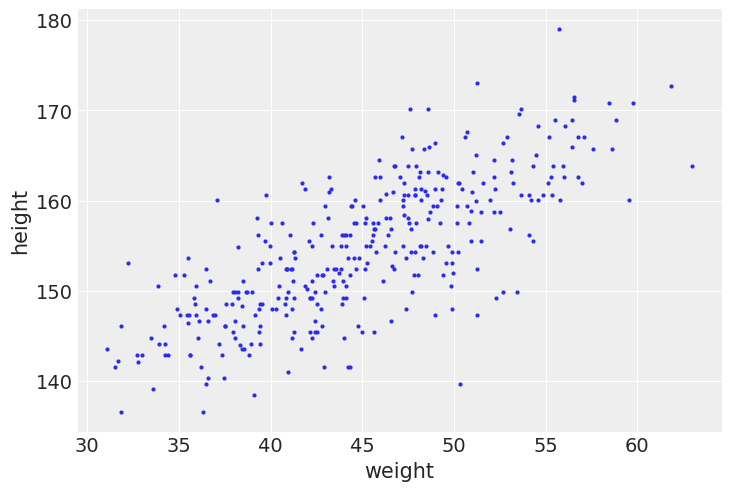

In [138]:
# 4.37
az.plot_pair(d2[['weight','height']].to_dict(orient='list'))
plt.show()

### 4.4.1 Linear model

We will first model height from weight, adapting the previous Gaussian model to weight the influence of weight (*badum-tss*):

$$h_i \sim \text{Normal}(u_i, σ)$$ [likelihood]

$$μ_i = α + β(x_i − \bar{x})$$ [linear model]

$$α \sim \text{Normal}(178, 20)$$ [α prior]

$$β \sim \text{Normal}(0, 10)$$ [β prior]

$$σ \sim \text{Uniform}(0, 50)$$ [σ prior]

In [139]:
# 4.38
# Simulations of alpha and beta values
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b = numpyro.sample('b', dist.Normal(0,10).expand([N]))

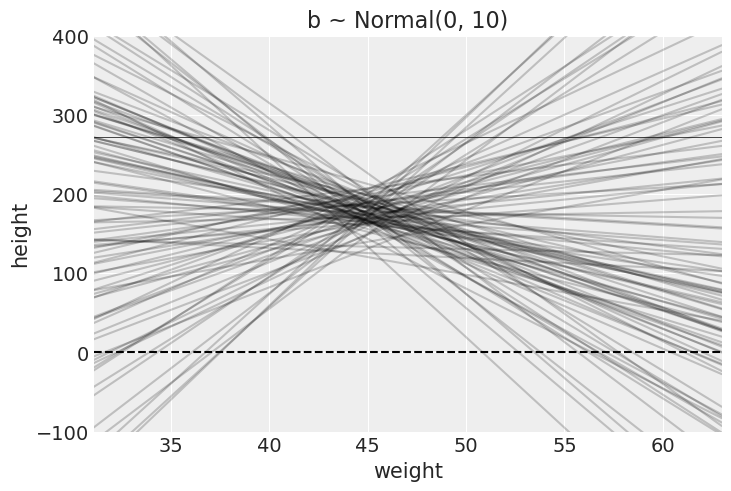

In [142]:
# 4.39
# Plot lines for simulated alpha and beta values
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100,400),
    ylabel='height',
    xlabel='weight',)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

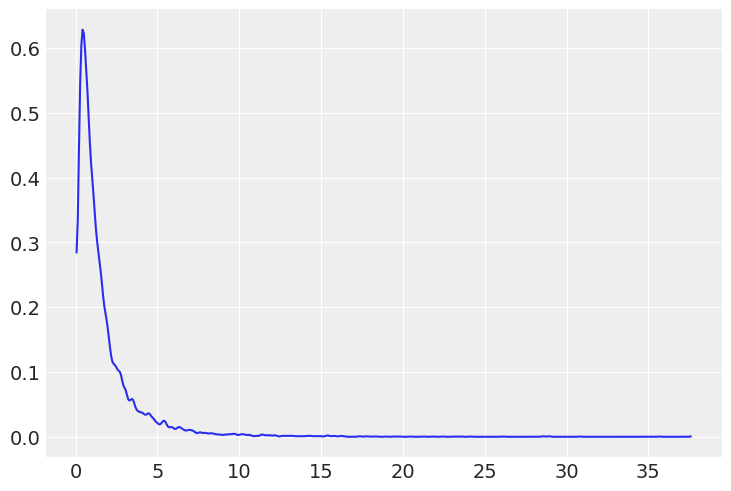

In [144]:
# 4.40
# Switch beta to Log-Normal instead to enforce positive relationships
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b)
plt.show()

In [145]:
# 4.41
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample('a', dist.Normal(178,20).expand([N]))
    b = numpyro.sample('b', dist.LogNormal(0,1).expand([N]))

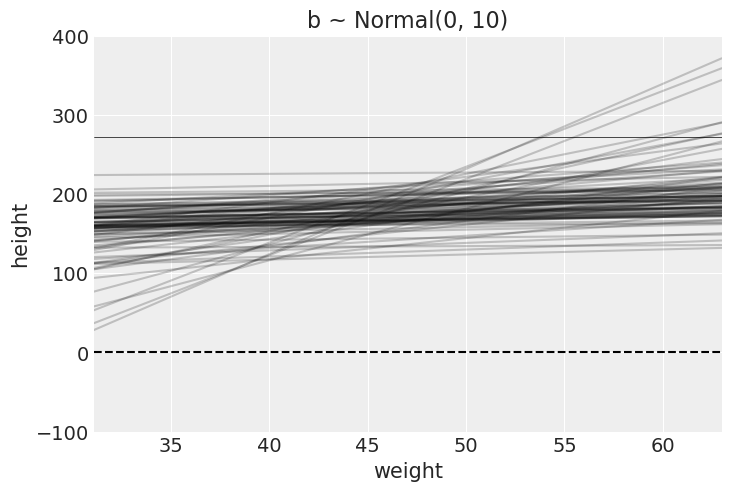

In [146]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100,400),
    ylabel='height',
    xlabel='weight',)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()